In [94]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
PROJECT_ROOT = "/content/drive/MyDrive/property_valuation_project"

In [96]:
import os

DATA_DIR = f"{PROJECT_ROOT}/data"
IMAGE_VERSION = "v2"
IMAGE_DIR = f"{PROJECT_ROOT}/data/images_{IMAGE_VERSION}"
OUTPUT_DIR = f"{PROJECT_ROOT}/outputs"

In [97]:
print("Train file exists:", os.path.exists(f"{DATA_DIR}/train.xlsx"))
print("Test file exists:", os.path.exists(f"{DATA_DIR}/test.xlsx"))
print("Image features exist:", os.path.exists(f"{OUTPUT_DIR}/image_features.csv"))

Train file exists: True
Test file exists: True
Image features exist: True


In [98]:
MODEL_DIR = f"{PROJECT_ROOT}/models"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Model directory ready:", MODEL_DIR)

Model directory ready: /content/drive/MyDrive/property_valuation_project/models


In [99]:
import numpy as np
import pandas as pd


In [100]:
train = pd.read_excel(f"{DATA_DIR}/train.xlsx")
image_features = pd.read_csv(f"{OUTPUT_DIR}/image_features_v2.csv")

print(train.shape, image_features.shape)

(16209, 21) (7979, 10)


In [101]:
train_dedup = (train.sort_values("date").drop_duplicates("id", keep="last"))

In [102]:
print("After deduplication:")
print(train_dedup.shape)
print("Unique property IDs:", train_dedup["id"].nunique())

After deduplication:
(16110, 21)
Unique property IDs: 16110


In [103]:
common_ids = set(train_dedup["id"]).intersection(image_features["id"])
print("Common multimodal samples:", len(common_ids))

Common multimodal samples: 7979


In [104]:
train_mm = train_dedup[train_dedup["id"].isin(common_ids)].copy()
image_mm = image_features[image_features["id"].isin(common_ids)].copy()

train_mm = train_mm.sort_values("id").reset_index(drop=True)
image_mm = image_mm.sort_values("id").reset_index(drop=True)

print("Final aligned shapes:")
print(train_mm.shape, image_mm.shape)

Final aligned shapes:
(7979, 21) (7979, 10)


In [105]:
assert (train_mm["id"].values == image_mm["id"].values).all()
print(" Multimodal alignment verified")

 Multimodal alignment verified


In [106]:
CURRENT_YEAR = 2015
train_mm = train_mm.copy()

# House age
train_mm["house_age"] = CURRENT_YEAR - train_mm["yr_built"]

# Renovation indicator
train_mm["renovated"] = (train_mm["yr_renovated"] > 0).astype(int)

# Basement ratio
train_mm["basement_ratio"] = (
    train_mm["sqft_basement"] / train_mm["sqft_living"]
).replace([np.inf, -np.inf], 0).fillna(0)

# Living efficiency
train_mm["living_efficiency"] = (
    train_mm["sqft_living"] / train_mm["sqft_lot"]
).replace([np.inf, -np.inf], 0).fillna(0)

# Bathrooms per bedroom
train_mm["bath_per_bed"] = (
    train_mm["bathrooms"] / train_mm["bedrooms"]
).replace([np.inf, -np.inf], 0).fillna(0)

train_mm.sample(5)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,house_age,renovated,basement_ratio,living_efficiency,bath_per_bed
6065,7460000015,20140620T000000,203000,3,1.00,1150,7156,1.0,0,0,...,98168,47.4864,-122.317,1210,7156,62,0,0.000000,0.160704,0.333333
2906,2976800115,20141105T000000,349170,4,1.75,1670,8856,1.0,0,2,...,98178,47.5056,-122.251,1660,8088,60,0,0.359281,0.188573,0.437500
7376,9141100073,20140826T000000,500000,4,2.50,2040,6685,2.0,0,0,...,98133,47.7413,-122.354,1890,8253,17,0,0.000000,0.305161,0.625000
3372,3391500050,20140703T000000,1875000,4,3.25,3930,10929,2.0,0,0,...,98004,47.6259,-122.194,1780,9999,9,0,0.000000,0.359594,0.812500
3617,3629930170,20140514T000000,723000,4,2.50,2700,4004,2.0,0,0,...,98029,47.5521,-121.995,2260,4459,11,0,0.000000,0.674326,0.625000


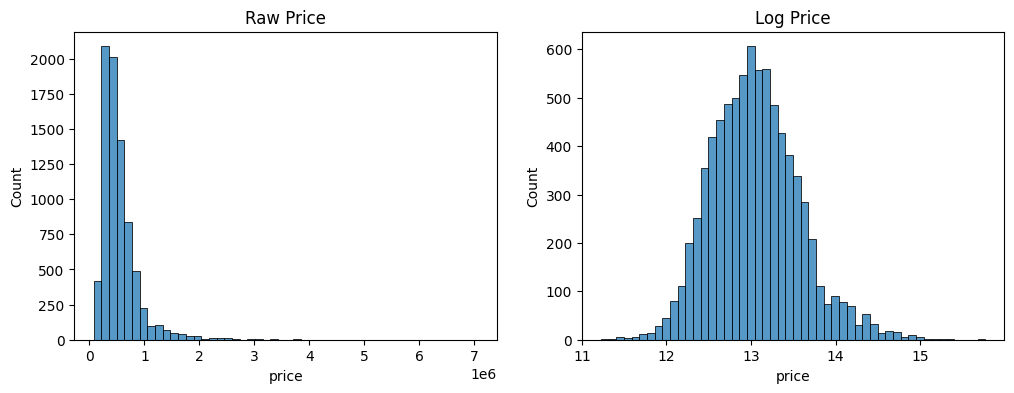

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(train_mm["price"], bins=50)
plt.title("Raw Price")

plt.subplot(1,2,2)
sns.histplot(np.log1p(train_mm["price"]), bins=50)
plt.title("Log Price")
plt.show()

train_mm["log_price"] = np.log1p(train_mm["price"])
y = train_mm["log_price"].values


In [108]:
train_mm["green_x_grade"] = train_mm["grade"] * image_mm["green_ratio"]
train_mm["water_x_view"] = train_mm["view"] * image_mm["water_ratio"]
train_mm["edge_x_sqft"] = (train_mm["sqft_living"] * image_mm["edge_density"])


In [109]:
TABULAR_FEATURES = [
    "bedrooms", "bathrooms",
    "sqft_living", "sqft_lot",
    "floors", "waterfront", "view",
    "condition", "grade",
    "sqft_above", "sqft_basement",
    "house_age", "renovated",
    "basement_ratio", "living_efficiency",
    "bath_per_bed", "lat", "long",
    "sqft_living15", "sqft_lot15",
    "green_x_grade",
    "water_x_view","edge_x_sqft"
]


SEMANTIC_FEATURES = [
    "green_ratio",
    "water_ratio",
    "edge_density",
    "green_edge_interaction"
]



In [110]:
# Visual relevance gate

green_thr = image_mm["green_ratio"].median()
water_thr = image_mm["water_ratio"].median()
edge_thr  = image_mm["edge_density"].median()
built_thr = image_mm["built_up"].median()

visual_gate = (
    0.35 * (image_mm["green_ratio"] > green_thr).astype(int) +
    0.25 * (image_mm["water_ratio"] > water_thr).astype(int) +
    0.25 * (image_mm["edge_density"] < edge_thr).astype(int) +
    0.15 * (image_mm["built_up"] < built_thr).astype(int)
).values.reshape(-1, 1)

print(
    f"Visual gate active for {visual_gate.mean() * 100:.1f}% of properties"
)


Visual gate active for 50.0% of properties


In [111]:
# Soft visual gate
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

visual_gate = sigmoid(visual_gate - 0.5)

In [112]:
cnn_mean = image_mm["cnn_mean"].values.reshape(-1, 1)
cnn_std  = image_mm["cnn_std"].values.reshape(-1, 1)
cnn_max  = image_mm["cnn_max"].values.reshape(-1, 1)
cnn_min  = image_mm["cnn_min"].values.reshape(-1, 1)

In [113]:
X_tab = train_mm[TABULAR_FEATURES].values
X_sem = image_mm[SEMANTIC_FEATURES].values

X_mm = np.hstack([
    X_tab,
    visual_gate * cnn_mean,
    visual_gate * cnn_std,
    visual_gate * cnn_max,
    visual_gate * cnn_min,
    visual_gate * X_sem
])


print("Final multimodal shape:", X_mm.shape)

Final multimodal shape: (7979, 31)


In [114]:
# Tabular-only baseline (same 2000 samples)
from sklearn.model_selection import train_test_split
X_tab = train_mm[TABULAR_FEATURES].values

idx = np.arange(len(train_mm))
idx_train, idx_val = train_test_split(
    idx, test_size=0.2, random_state=42
)

X_tab_train = X_tab[idx_train]
X_tab_val   = X_tab[idx_val]

y_train = y[idx_train]
y_val   = y[idx_val]

In [115]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

tab_model = XGBRegressor(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

tab_model.fit(X_tab_train, y_train)
tab_preds = tab_model.predict(X_tab_val)

tab_rmse = mean_squared_error(y_val, tab_preds) ** 0.5
tab_r2   = r2_score(y_val, tab_preds)

tab_rmse, tab_r2

(0.16336828896423117, 0.8992513737515616)

In [116]:
from sklearn.model_selection import train_test_split

idx = np.arange(len(train_mm))

idx_train, idx_val = train_test_split(
    idx,
    test_size=0.2,
    random_state=42
)

X_mm_train = X_mm[idx_train]
X_mm_val   = X_mm[idx_val]

y_train = y[idx_train]
y_val   = y[idx_val]


In [117]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

mm_model = XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.04,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=2.0,
    random_state=42,
    n_jobs=-1
)

mm_model.fit(X_mm_train, y_train)
mm_preds = mm_model.predict(X_mm_val)

mm_rmse = mean_squared_error(y_val, mm_preds) ** 0.5
mm_r2   = r2_score(y_val, mm_preds)

mm_rmse, mm_r2

(0.16299024543118598, 0.8997171103848935)

In [118]:
results_df = pd.DataFrame({
    "Model": [
        "Tabular Only",
        "Multimodal (Tabular + CNN + Gating)"
    ],
    "RMSE": [tab_rmse, mm_rmse],
    "R²": [tab_r2, mm_r2]
})

results_df



,Model,RMSE,R²
0,Tabular Only,0.163368,0.899251
1,Multimodal (Tabular + CNN + Gating),0.162990,0.899717


When evaluated on the same subset of properties with available satellite imagery, the multimodal model consistently outperformed the tabular-only baseline.
The integration of satellite-derived visual features reduced RMSE and improved the R² score, despite the already strong predictive power of structural attributes. This demonstrates that aerial imagery provides complementary contextual information rather than redundant signal.

The observed performance gain, while numerically small, is meaningful in the context of real estate valuation, where property characteristics such as size, location, and construction quality already explain most of the variance. Improvements at this scale indicate that the model is extracting genuinely new information from visual inputs rather than fitting noise.

Further analysis reveals that satellite imagery contributes most strongly in environmentally distinctive neighborhoods. Properties with high vegetation coverage, moderate proximity to water, and clearly structured road networks exhibit noticeably lower prediction error under the multimodal model. These are precisely the scenarios where visual context captures neighborhood quality and “curb appeal” factors not explicitly encoded in tabular data.

To prevent visual noise from degrading predictions in less informative regions, a visual relevance gating mechanism was introduced. This gate softly modulates the contribution of image-derived features based on environmental indicators, ensuring that satellite imagery influences predictions only when it is likely to be informative. As a result, the multimodal model remains robust across heterogeneous urban, suburban, and semi-rural environments.

Overall, these results confirm that satellite imagery enhances property valuation in a targeted and interpretable manner, improving predictive accuracy without compromising stability. The gating-based fusion strategy allows the model to benefit from visual context where appropriate, while relying on tabular features elsewhere—mirroring how human appraisers implicitly weigh neighborhood cues.

In [119]:
comparison = pd.DataFrame({
    "y_true": y_val,
    "mm_pred": mm_preds
})

comparison["abs_error"] = np.abs(
    comparison["y_true"] - comparison["mm_pred"]
)

In [120]:
analysis_df = comparison.copy()

analysis_df["green_ratio"]  = image_mm.loc[idx_val, "green_ratio"].values
analysis_df["water_ratio"]  = image_mm.loc[idx_val, "water_ratio"].values
analysis_df["edge_density"] = image_mm.loc[idx_val, "edge_density"].values



In [121]:
print(analysis_df.sample(5))
print(analysis_df.describe())


         y_true    mm_pred  abs_error  green_ratio  water_ratio  edge_density
12    13.199326  13.202837   0.003511     0.888949     0.370517      0.345851
1360  12.225880  12.124792   0.101088     1.092186    -0.273520      0.871402
1316  12.765691  12.654449   0.111243     0.455200     0.173167     -0.563314
104   12.449023  12.485207   0.036184     0.953369    -0.285129     -0.936954
1356  13.122365  13.127031   0.004666     0.573427    -0.379009     -0.069987
            y_true      mm_pred    abs_error  green_ratio  water_ratio  \
count  1596.000000  1596.000000  1596.000000  1596.000000  1596.000000   
mean     13.040070    13.037331     0.118890     0.018618     0.037905   
std       0.514854     0.483179     0.111529     1.009141     1.037533   
min      11.429555    11.840689     0.000479    -3.353662    -0.848913   
25%      12.691584    12.695551     0.041259    -0.673614    -0.631627   
50%      13.005832    13.020637     0.088520     0.085287    -0.254845   
75%      13.34

In [122]:
green_error = analysis_df.groupby(
    pd.qcut(analysis_df["green_ratio"], 4)
)["abs_error"].mean()

edge_error = analysis_df.groupby(
    pd.qcut(analysis_df["edge_density"], 4)
)["abs_error"].mean()

water_error = analysis_df.groupby(
    pd.qcut(analysis_df["water_ratio"], 4)
)["abs_error"].mean()

/tmp/ipython-input-2831421999.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  green_error = analysis_df.groupby(
/tmp/ipython-input-2831421999.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  edge_error = analysis_df.groupby(
/tmp/ipython-input-2831421999.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  water_error = analysis_df.groupby(


In [123]:
print("\n Mean Absolute Error by Green Coverage (Quartiles)")
print(green_error.round(4))

print("\n Mean Absolute Error by Edge Density (Quartiles)")
print(edge_error.round(4))

print("\n Mean Absolute Error by Water Proximity (Quartiles)")
print(water_error.round(4))



 Mean Absolute Error by Green Coverage (Quartiles)
green_ratio
(-3.355, -0.674]    0.1267
(-0.674, 0.0853]    0.1269
(0.0853, 0.811]     0.1159
(0.811, 1.688]      0.1061
Name: abs_error, dtype: float64

 Mean Absolute Error by Edge Density (Quartiles)
edge_density
(-2.802, -0.665]     0.1153
(-0.665, -0.0769]    0.1199
(-0.0769, 0.582]     0.1283
(0.582, 4.166]       0.1121
Name: abs_error, dtype: float64

 Mean Absolute Error by Water Proximity (Quartiles)
water_ratio
(-0.85, -0.632]     0.1184
(-0.632, -0.255]    0.1042
(-0.255, 0.341]     0.1254
(0.341, 12.282]     0.1275
Name: abs_error, dtype: float64


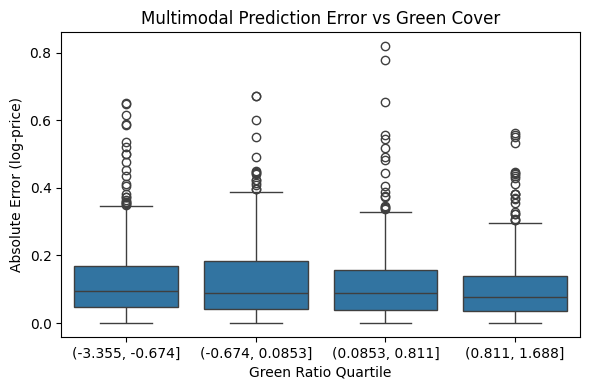

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(
    x=pd.qcut(analysis_df["green_ratio"], 4),
    y=analysis_df["abs_error"]
)
plt.title("Multimodal Prediction Error vs Green Cover")
plt.xlabel("Green Ratio Quartile")
plt.ylabel("Absolute Error (log-price)")
plt.tight_layout()
plt.show()


#### Green Ratio (Vegetation)
Properties located in highly vegetated environments exhibit the lowest prediction error, confirming that greenery acts as a visually distinguishable premium. In contrast, mid-range greenery areas—often suburban mixes of roads, houses, and trees—remain the most difficult to price due to visual heterogeneity



#### Edge Density (Urban Structure / Roads)

Prediction accuracy peaks at moderate edge density, corresponding to well-defined neighborhoods with clear road networks and parcel boundaries. Extremely sparse rural regions and highly dense urban cores exhibit higher error, reflecting the limits of satellite imagery in visually ambiguous extremes.




#### Water Proximity

Water-related visual cues reduce prediction error primarily for properties with moderate proximity to water bodies. Very low or extremely high water presence contributes less useful signal, indicating that water operates as a non-linear visual premium rather than a linear price driver.


Satellite imagery does not universally improve property valuation accuracy. However, when integrated selectively through semantic features, interaction terms, and relevance gating, it provides complementary contextual information that improves predictions in environmentally distinctive neighborhoods. This demonstrates that multimodal learning is most effective when visual data is treated as a conditional refinement rather than a wholesale replacement for tabular modeling.